In [1]:
# Access parent directories
from sys import path
from os.path import abspath
path += [abspath("../"*i) for i in (1, 2, 3)]

In [2]:
# Imports
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from IPython import display
from QLab import ReplayMemory, QNetwork, Qptimizer
from QLearning.utilities import quickplot

pygame 2.1.2 (SDL 2.0.16, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
env = gym.make('MsPacman-v0')
is_ipython = 'inline' in matplotlib.get_backend()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.ion()

9
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


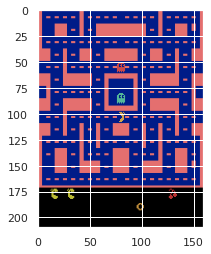

In [4]:
color = np.array([210, 164, 74]).mean()
def preprocess_observation(obs):
    # Crop and resize the image
    img = obs[1:176:2, ::2]
    # Convert the image to greyscale
    img = img.mean(axis=2)
    # Improve image contrast
    img[img==color] = 0
    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1
    return img.reshape(88,80,1).transpose((2,0,1))
    
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())

observation = env.reset()

import matplotlib.pyplot as plt


for i in range(22):
  
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)

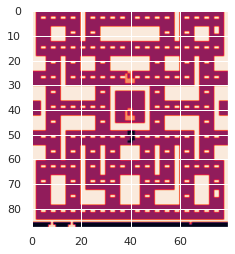

In [5]:
def get_screen():
	obs = env.render(mode='rgb_array')
	return torch.tensor(preprocess_observation(obs), dtype=torch.float32)

plt.imshow(np.array(get_screen()).transpose((1, 2, 0)))
plt.show()

In [6]:
# Transition = namedtuple('Transition',
#                         ('state', 'action', 'reward', 'next_state'))


# class ReplayMemory(object):

#     def __init__(self, capacity):
#         self.memory = deque([],maxlen=capacity)

#     def push(self, state, action, reward, next_state):
#         """Save a transition"""
#         if next_state is not None:
#             next_state = next_state.unsqueeze(0)
#         self.memory.append(Transition(
#             state.unsqueeze(0),
#             action[0],
#             reward,
#             next_state
#         ))

#     def sample(self, batch_size):
#         return random.sample(self.memory, batch_size)

#     def __len__(self):
#         return len(self.memory)

In [7]:
class DQN(QNetwork):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [8]:
epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

steps_done = 0
def select_action(state):
	global steps_done
	sample = random.random()
	epsilon = max(eps_min, eps_max - (eps_max - eps_min) * steps_done / eps_decay_steps)
	steps_done += 1
	if sample > epsilon:
		with torch.no_grad():
			# t.max(1) will return largest column value of each row.
			# second column on max result is index of where max element was
			# found, so we pick action with the larger expected reward.
			return policy_net(state.unsqueeze(0)).max(1)[1].view(1, 1)
	else:
		return torch.tensor([[random.randrange(9)]], device=device, dtype=torch.long)


In [9]:
# num_episodes = 800
# batch_size = 48
# input_shape = (None, 88, 80, 1)
# #Recall shape is img.reshape(88,80,1)
# X_shape = (None, 88, 80, 1)
# discount_factor = 0.97

learning_rate = 0.001
global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

policy_net = DQN(88, 80, 9)
target_net = policy_net.clone()
memory = ReplayMemory(20000)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
optimizer = Qptimizer(memory, optimizer, policy_net, target_net)

In [10]:
num_episodes = 1000
rewards = []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    reward_acc = 0
    for t in count():
        env.render()
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        reward_acc += reward

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()

        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action[0][0], reward[0], next_state)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimizer(gamma = 0.97)
        if done:
            rewards.append(reward_acc)
            reward_acc = 0
            quickplot(rewards, "Score", path = "./score")
            optimizer.plot_loss()
            optimizer.plot_loss_variance()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % copy_steps == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.close()
plt.ioff()
plt.show()

/home/ventus/.local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/ventus/.local/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Complete


TypeError: save() missing 1 required positional argument: 'path'

<Figure size 432x288 with 0 Axes>

In [ ]:
policy_net.save('./demo')